Firgure 1: Opportunity Sets of Risky Assets and Portfolios


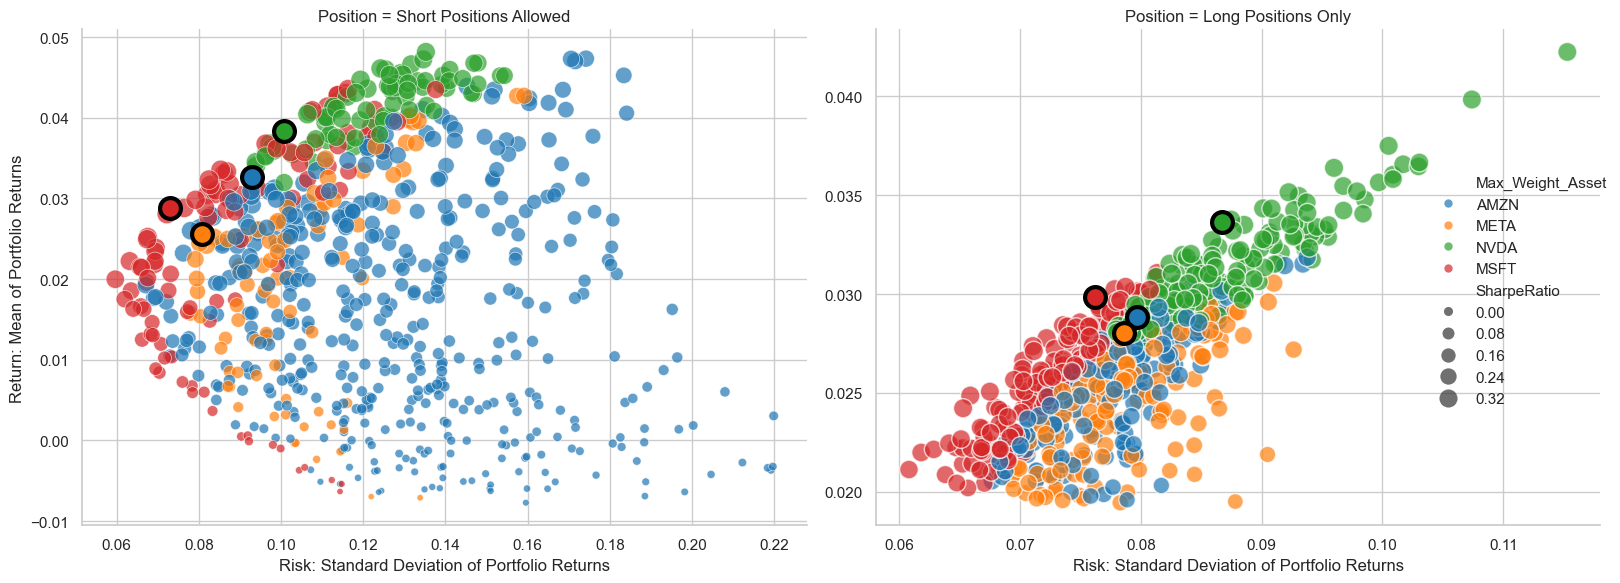

In [176]:
# loading libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# define my asset list
symbols = ['NVDA', 'META', 'MSFT', 'AMZN']
start_date = '2015-01-01'
end_date = '2025-06-30'

# download historical data using individual tickers and merge
adj_close = pd.DataFrame()
for symbol in symbols:
    ticker = yf.Ticker(symbol)
    historical_data = ticker.history(start=start_date, end=end_date, interval='1mo')
    adj_close[symbol] = historical_data['Close']

adj_close = adj_close.dropna()

# calculate log returns
log_returns = np.log(adj_close / adj_close.shift(1)).dropna()
mean_returns = log_returns.mean().values
cov_matrix = log_returns.cov().values

# sample size for Monte Carlo simulation
sample_size = 700

# generate random weights
np.random.seed(9999)
def make_weights(shorts_ok):
    if shorts_ok:
        weights = np.random.uniform(-1, 1, 3)
        fourth_weight = 1 - np.sum(weights)
        return np.append(weights, fourth_weight)
    else:
        weights = np.random.uniform(0, 1, 4)
        return weights / np.sum(weights)
        
# assuming risk-free rate = 0
risk_free_rate = 0.0

# simulate portfolios
def simulate_portfolios(shorts_ok):
    weights_matrix = np.array([make_weights(shorts_ok) for _ in range(sample_size)])
    port_returns = weights_matrix @ mean_returns
    port_stds = np.sqrt(np.einsum('ij,jk,ik->i', weights_matrix, cov_matrix, weights_matrix))
    sharpe_ratios = (port_returns - risk_free_rate) / port_stds

    max_weight_assets = [symbols[np.argmax(w)] for w in weights_matrix]
    has_shorts = np.any(weights_matrix < 0, axis=1)

    results = pd.DataFrame({
        'w1': weights_matrix[:,0],
        'w2': weights_matrix[:,1],
        'w3': weights_matrix[:,2],
        'w4': weights_matrix[:,3],
        'Max_Weight_Asset': max_weight_assets,
        'Positions': np.where(has_shorts, 'Has Short(s)', 'No Shorts'),
        'returnMean': port_returns,
        'returnSD': port_stds,
        'SharpeRatio': sharpe_ratios,
        'Position': 'Short Positions Allowed' if shorts_ok else 'Long Positions Only'
    })
    return results

# run both simulations
shorts_ok_results = simulate_portfolios(shorts_ok=True)
no_shorts_results = simulate_portfolios(shorts_ok=False)
plotting_frame = pd.concat([shorts_ok_results, no_shorts_results], ignore_index=True)

# plot the results with asset coloring as well as the sharpe ratios
g = sns.relplot(
    data=plotting_frame,
    x="returnSD",
    y="returnMean",
    hue="Max_Weight_Asset",
    size="SharpeRatio",
    sizes=(20, 200),
    alpha=0.7,
    col="Position",
    height=6,
    aspect=1.2,
    facet_kws={'sharex': False, 'sharey': False},
    palette='tab10'
)

positions = plotting_frame["Position"].unique()
assets = plotting_frame["Max_Weight_Asset"].unique()

for ax, position in zip(g.axes.flat, positions):
    for asset in assets:
        subset = plotting_frame[
            (plotting_frame["Position"] == position) &
            (plotting_frame["Max_Weight_Asset"] == asset)
        ]
        if not subset.empty:
            top = subset.loc[subset["SharpeRatio"].idxmax()]
            palette = sns.color_palette("tab10", n_colors=len(assets))
            palette_dict = dict(zip(assets, palette))
            color = palette_dict.get(asset, 'gray')
            ax.plot(
    top["returnSD"],
    top["returnMean"],
    marker='o',
    markersize=15,
    markerfacecolor=color,
    markeredgewidth=3,
    markeredgecolor='black',
    zorder=10
)

g.set_axis_labels("Risk: Standard Deviation of Portfolio Returns", "Return: Mean of Portfolio Returns")

print("Firgure 1: Opportunity Sets of Risky Assets and Portfolios")

plt.tight_layout()
plt.savefig("Asset-Portfolio-Monte-Carlo-2025.pdf", bbox_inches='tight')
plt.show()

In [174]:
# create df for highest sharpe ratios
summary_data = {
    'Asset': [],
    'SharpeRatio_ShortAllowed': [],
    'SharpeRatio_LongOnly': []
}

assets = plotting_frame["Max_Weight_Asset"].unique()

for asset in assets:
    short_allowed = plotting_frame[
        (plotting_frame["Max_Weight_Asset"] == asset) & 
        (plotting_frame["Position"] == "Short Positions Allowed")
    ]
    long_only = plotting_frame[
        (plotting_frame["Max_Weight_Asset"] == asset) & 
        (plotting_frame["Position"] == "Long Positions Only")
    ]
    
    top_short = short_allowed["SharpeRatio"].max() if not short_allowed.empty else np.nan
    top_long = long_only["SharpeRatio"].max() if not long_only.empty else np.nan
    
    summary_data['Asset'].append(asset)
    summary_data['SharpeRatio_ShortAllowed'].append(top_short)
    summary_data['SharpeRatio_LongOnly'].append(top_long)

summary_df = pd.DataFrame(summary_data)

# print sharpe ratio table
print("Table 1: Highest Sharpe Ratios for Each Asset under Portfolio Constraints\n")
print(summary_df.to_string(index=False, float_format="{:.4f}".format))

Table 1: Highest Sharpe Ratios for Each Asset under Portfolio Constraints

Asset  SharpeRatio_ShortAllowed  SharpeRatio_LongOnly
 AMZN                    0.3517                0.3620
 META                    0.3168                0.3567
 NVDA                    0.3809                0.3883
 MSFT                    0.3952                0.3919
